In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.gofplots import qqplot
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
# SimpleImputer does not have get_feature_names_out, so we need to add it manually.
SimpleImputer.get_feature_names_out = (lambda self, names = None: self.feature_names_in_)
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import set_config; set_config(display='diagram')
from sklearn.metrics import mean_squared_error, make_scorer
import sklearn.metrics as metrics

from xgboost import XGBRegressor
from sklearn_evaluation import plot

import pickle

from housing_crawler.ads_table_processing import get_processed_ads_table
from housing_crawler.utils import return_significative_coef

%load_ext autoreload
%autoreload 2

In [2]:
# sklearndf is an sklearn alternative that returns dataframes from transformers instead of np.arrays
# https://github.com/BCG-Gamma/sklearndf
from sklearndf.transformation import ColumnTransformerDF,OneHotEncoderDF,SimpleImputerDF,StandardScalerDF,RobustScalerDF,MinMaxScalerDF
from sklearndf.pipeline import PipelineDF

# Prepare data

## Obtain data for WGs

In [3]:
df_original = get_processed_ads_table()


===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29919 entries, 0 to 29929
Columns: 146 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(117), int64(5), object(18)
memory usage: 33.6+ MB


In [5]:
ads_feat_df = df_original[df_original['details_searched']==1]
# ads_feat_df = ads_feat_df[ads_feat_df['city'].isin(['Berlin'])]#, 'München', 'Hamburg', 'Stuttgart', 'Köln', 'Münster', 'Leipzig', 'Frankfurt am Main'])]
ads_feat_df = ads_feat_df.set_index('id')

In [6]:
# Set target for estimations
target = 'price_per_sqm_cold'

## Remove duplicates if exist

In [7]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

## Filter data accordingly

In [8]:
# Filter only ads that have been searched for details (search added from august on)
df_filtered = ads_feat_df.copy()
df_filtered = df_filtered[df_filtered['type_offer_simple']=='WG']
df_filtered = df_filtered[df_filtered['km_to_centroid'].notna()]
df_filtered = df_filtered.drop(columns=['details_searched','type_offer_simple'])
# df_filtered["price_per_sqm_cold"] = np.log2(df_filtered["price_per_sqm_cold"])
df_filtered.describe()

,commercial_landlord,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,male_flatmates,female_flatmates,diverse_flatmates,published_at,latitude,longitude,cold_rent_euros,mandatory_costs_euros,extra_costs_euros,transfer_costs_euros,schufa_needed,deposit,zip_code,wg_possible,building_floor,public_transport_distance,home_total_size,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,construction_year,energy_usage,energy_efficiency_class,price_per_sqm_warm,price_per_sqm_cold,number_languages,internet_speed,toilet,internet_dsl,internet_wlan,internet_flatrate,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,tv_kabel,tv_satellit,days_available,furniture_numerical,kitchen_numerical,smoking_numerical,room_size_house_fraction,flat_with_kids,km_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,activities_public_service,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,comfort_green_forests,mobility_street_primary,comfort_lakes,activities_health_regional,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,sin_degrees_to_centroid,cos_degrees_to_centroid,sin_published_at,cos_published_at,sin_day_week_int,cos_day_week_int
count,9074.000000,9074.000000,9074.000000,9074.0,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,7416.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9060.000000,9074.0,8067.000000,7965.000000,6293.000000,6827.000000,6385.000000,9074.000000,9074.000000,1028.000000,322.000000,468.000000,9074.000000,9074.000000,9074.000000,2738.000000,17.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.00000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,6293.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9.074000e+03,9074.000000,9074.000000,9074.000000,9.074000e+03,9074.0,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.0,9074.000000,9074.000000,9074.0,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,7.416000e+03,7416.000000,9074.000000,9074.000000
mean,0.007494,481.201124,17.276725,1.0,3.253802,1.251047,0.957351,1.029094,0.016310,14.984223,50.919665,10.210487,386.742010,59.158916,6.714238,30.996253,0.085188,570.355742,45007.697903,1.0,1.993988,3.218581,91.826315,24.436356,29.973532,13.664646,58.709059,1945.6459

# Preprocessing pipeline

In [9]:
X = df_filtered.drop(columns=target)
y = df_filtered[[target]].reset_index()

## Select columns per pipeline

In [10]:
columns_to_remove = []

In [11]:
features_OSM = [
                'comfort_leisure_spots',
                'comfort_warehouse',
                'activities_education',
                'mobility_public_transport_bus',
                'activities_economic',
                'comfort_industrial', # Has not been blurried?
#                 'activities_goverment', # I can't even plot it. There's something weird
                'social_life_eating',
                'comfort_comfort_spots',
                'social_life_culture',
#                 'activities_supermarket', # I can't even plot it. There's something weird
#                 'activities_public_service', # Data is constant
                'social_life_community',
                'comfort_leisure_mass',
                'activities_educational',
                'mobility_street_secondary', # Has not been blurried?
                'mobility_public_transport_rail',
                'activities_retail', # Has not been blurried?
                'social_life_night_life',
#                 'comfort_green_natural', # I can't even plot it. There's something weird
                'comfort_railway', # Has not been blurried?
                'mobility_bike_infraestructure', # Has not been blurried
#                 'comfort_green_forests', # Data is constant
                'mobility_street_primary', # Has not been blurried?
                'comfort_lakes', # Has not been blurried?
#                 'activities_health_regional', # Data is constant
                'activities_health_local',
                'comfort_green_space', # Has not been blurried
#                 'comfort_rivers', # I can't even plot it. There's something weird
                'activities_post',
                'comfort_green_parks', # Has not been blurried?
#                 'comfort_street_motorway' # Has not been blurried. Empty?
]

In [12]:
features_already_OHE = ['tv_kabel','tv_satellit',
                        
                        'shower_type_badewanne','shower_type_dusche',
                                   
                       'floor_type_dielen','floor_type_parkett','floor_type_laminat','floor_type_teppich',
                       'floor_type_fliesen','floor_type_pvc','floor_type_fußbodenheizung',

                       'extras_waschmaschine','extras_spuelmaschine','extras_terrasse','extras_balkon',
                       'extras_garten','extras_gartenmitbenutzung','extras_keller','extras_aufzug',
                       'extras_haustiere','extras_fahrradkeller','extras_dachboden',

                       'languages_deutsch','languages_englisch',

                       'wg_type_studenten','wg_type_keine_zweck','wg_type_maenner','wg_type_business',
                       'wg_type_wohnheim','wg_type_vegetarisch_vegan','wg_type_alleinerziehende','wg_type_funktionale',
                       'wg_type_berufstaetigen','wg_type_gemischte','wg_type_mit_kindern','wg_type_verbindung',
                       'wg_type_lgbtqia','wg_type_senioren','wg_type_inklusive','wg_type_wg_neugruendung',

                       'internet_dsl','internet_wlan','internet_flatrate']

In [13]:
# Leave no remainder columns. All columns should be included in one category below

cols_PowerTrans_SimpImpMean = ['km_to_centroid',#'size_sqm',
                                'min_age_flatmates', 'max_age_flatmates', 'home_total_size',# 'days_available',
                               'room_size_house_fraction']
cols_PowerTrans_SimpImpMedian_MinMaxScaler = features_OSM + ['min_age_searched', 'max_age_searched','public_transport_distance','number_languages']
cols_PowerTrans_SimpImpMean_RobustScaler = []

cols_SimpImpMean_StandardScaler = []
cols_SimpImpMean_MinMaxScaler = ['internet_speed','sin_degrees_to_centroid', 'cos_degrees_to_centroid']
cols_SimpImpMean_RobustScaler = []

cols_SimpImpMedian_StandardScaler = [] 
cols_SimpImpMedian_MinMaxScaler = ['commercial_landlord','capacity',
                                   'male_flatmates', 'female_flatmates', 'diverse_flatmates','flat_with_kids',
                                   'schufa_needed','smoking_numerical', 'building_floor', 
                                   'furniture_numerical', 'kitchen_numerical'] + features_already_OHE
cols_SimpImpMedian_RobustScaler = []
cols_SimpImpConst0_PowerTrans_MinMaxScaler = ['transfer_costs_euros']
cols_SimpImpConstNoAns_OHE = ['city','rental_length_term','gender_searched','building_type','heating', 'parking'] 

original_cols = cols_PowerTrans_SimpImpMean+cols_PowerTrans_SimpImpMedian_MinMaxScaler+cols_PowerTrans_SimpImpMean_RobustScaler+\
        cols_SimpImpMean_StandardScaler+cols_SimpImpMean_MinMaxScaler+cols_SimpImpMean_RobustScaler+cols_SimpImpMedian_StandardScaler\
   +cols_SimpImpMedian_MinMaxScaler+cols_SimpImpMedian_RobustScaler+cols_SimpImpConst0_PowerTrans_MinMaxScaler+cols_SimpImpConstNoAns_OHE

len(original_cols)

97

## Build the imputter/scaler pairs

In [14]:
PowerTrans_SimpImpMean = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('PowerTransformer', PowerTransformer())    
])

PowerTrans_SimpImpMedian_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="median")),
    ('PowerTransformer', PowerTransformer()),
    ('MinMaxScaler', MinMaxScaler())
])

# SimpImpMean_StandardScaler = Pipeline([
#     ('SimpleImputer', SimpleImputer(strategy="mean")),
#     ('StandardScaler', StandardScaler())
# ])

SimpImpMean_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('MinMaxScaler', MinMaxScaler())
])

# SimpImpMean_RobustScaler = Pipeline([
#     ('SimpleImputer', SimpleImputer(strategy="mean")),
#     ('RobustScaler', RobustScaler())
# ])

# SimpImpMedian_StandardScaler = Pipeline([
#     ('SimpleImputer', SimpleImputer(strategy="median")),
#     ('StandardScaler', StandardScaler())
# ])

SimpImpMedian_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="median")),
    ('MinMaxScaler', MinMaxScaler())
])

# SimpImpMedian_RobustScaler = Pipeline([
#     ('SimpleImputer', SimpleImputer(strategy="median")),
#     ('RobustScaler', RobustScaler())
# ])

SimpImpConst0_PowerTrans_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="constant", fill_value=0)),
    ('PowerTransformer', PowerTransformer()),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpConstNoAns_OHE = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="constant", fill_value='no_answer')),
    ('OHE', OneHotEncoder(sparse=False, drop='if_binary', categories='auto'))
])

## Build column transformer pipeline

In [15]:
class columnDropperTransformer(ColumnTransformer):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [16]:
preprocessor_transformer = ColumnTransformer([
    ('pipeline-1', PowerTrans_SimpImpMean, cols_PowerTrans_SimpImpMean),
    ('pipeline-2', PowerTrans_SimpImpMedian_MinMaxScaler, cols_PowerTrans_SimpImpMedian_MinMaxScaler),
    ('pipeline-3', SimpImpMean_MinMaxScaler, cols_SimpImpMean_MinMaxScaler),
    ('pipeline-4', SimpImpMedian_MinMaxScaler, cols_SimpImpMedian_MinMaxScaler),
    ('pipeline-5', SimpImpConst0_PowerTrans_MinMaxScaler, cols_SimpImpConst0_PowerTrans_MinMaxScaler),
    ('pipeline-6', SimpImpConstNoAns_OHE, cols_SimpImpConstNoAns_OHE)
     ],
    remainder='drop',
    verbose_feature_names_out=False)
preprocessor_transformer

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['km_to_centroid', 'min_age_flatmates',
                                  'max_age_flatmates', 'home_total_size',
                                  'room_size_house_fraction']),
                                ('pipeline-2',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('PowerTransformer',
                                                  PowerT...
                                                  PowerTransformer()),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['transfer_costs_euros']),
                                ('pipeline-6',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(fill_value='no_answer',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 ['city', 'rental_length_term',
                                  'gender_searched', 'building_type', 'heating',
                                  'parking'])],
                  verbose_feature_names_out=False)

## Create df_processed for further analysis of feature relevance

In [17]:
# Get transformed table with corresponding column names
df_processed = pd.DataFrame(
                            preprocessor_transformer.fit_transform(X), 
                            columns=preprocessor_transformer.get_feature_names_out()
                            )

# Remove the prefix from the column names
# df_processed.columns = [col.split('__')[1].lower().replace('ü','ue').replace('ä','ae').replace('ö','oe').replace('-wg','').replace(' wg','').replace('wg ','')\
#         .replace(' ','_').replace('/','_').replace('-','_').replace('+','') for col in df_processed.columns]

# Merge target back
df_processed=pd.concat([y,df_processed],axis=1).set_index(keys='id')
                          
df_processed.describe()

,price_per_sqm_cold,km_to_centroid,min_age_flatmates,max_age_flatmates,home_total_size,room_size_house_fraction,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,social_life_eating,comfort_comfort_spots,social_life_culture,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,activities_post,comfort_green_parks,min_age_searched,max_age_searched,public_transport_distance,number_languages,internet_speed,sin_degrees_to_centroid,cos_degrees_to_centroid,commercial_landlord,capacity,male_flatmates,female_flatmates,diverse_flatmates,flat_with_kids,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_dsl,internet_wlan,internet_flatrate,transfer_costs_euros,city_Aachen,city_Berlin,city_Bonn,city_Bremen,city_Darmstadt,city_Dresden,city_Frankfurt am Main,city_Göttingen,city_Hamburg,city_Hannover,city_Heidelberg,city_Karlsruhe,city_Kiel,city_Köln,city_Leipzig,city_Mainz,city_Mannheim,city_München,city_Münster,city_Nürnberg,city_Regensburg,city_Stuttgart,city_Tübingen,city_Würzburg,rental_length_term_180days,rental_length_term_270days,rental_length_term_30days,rental_length_term_365days,rental_length_term_540days,rental_length_term_90days,rental_length_term_plus540days,gender_searched_Divers,gender_searched_Egal,gender_searched_Frau,gender_searched_Mann,building_type_Altbau,building_type_Doppelhaus,building_type_Einfamilienhaus,building_type_Hochhaus,building_type_Mehrfamilienhaus,building_type_Neubau,building_type_Plattenbau,building_type_Reihenhaus,building_type_no_answer,building_type_sanierter Altbau,heating_Fernwärme,heating_Gasheizung,heating_Kohleofen,heating_Nachtspeicherofen,heating_Ofenheizung,heating_Zentralheizung,heating_no_answer,parking_Bewohnerparken,parking_Tiefgaragenstellplatz,parking_eigener Parkplatz,parking_gute Parkmöglichkeiten,parking_no_answer,parking_schlechte Parkmöglichkeiten
count,9074.000000,9.074000e+03,9.074000e+03,9.074000e+03,9.074000e+03,9.074000e+03,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.00000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000

In [18]:
df_processed.shape

(9074, 150)

## Compare original and transformed data

/tmp/ipykernel_17663/2126200453.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))


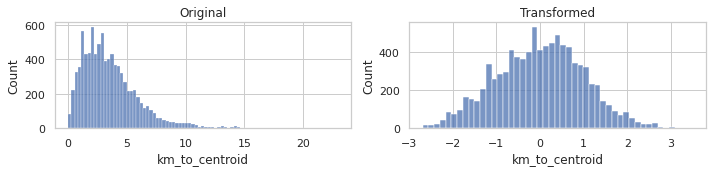

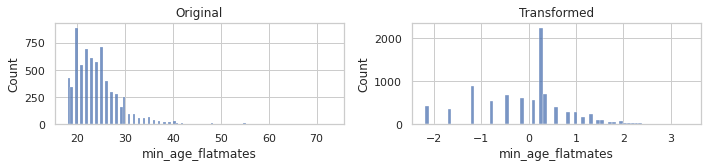

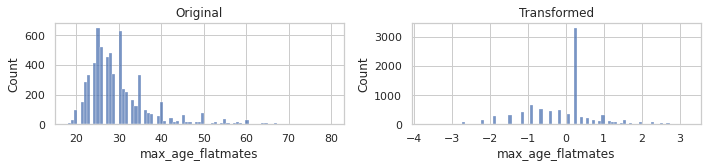

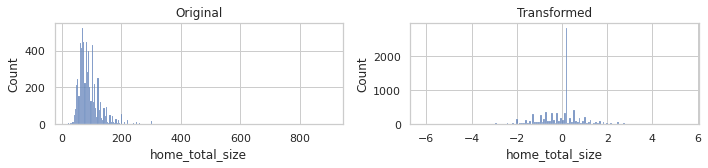

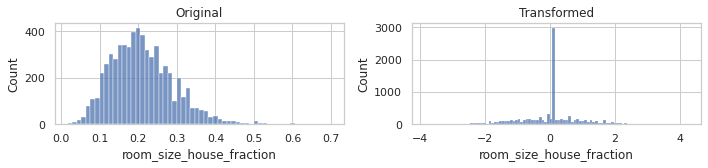

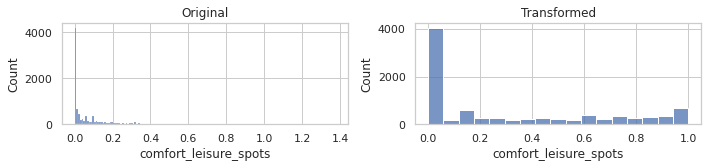

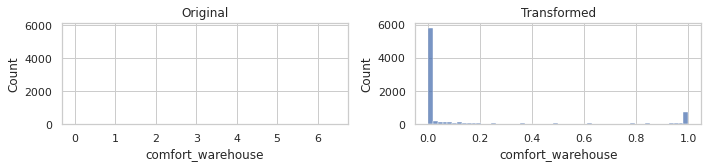

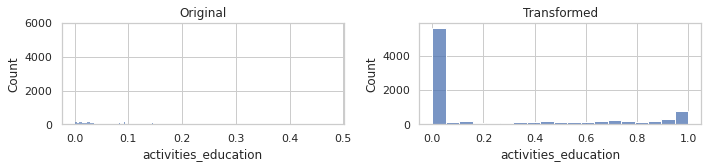

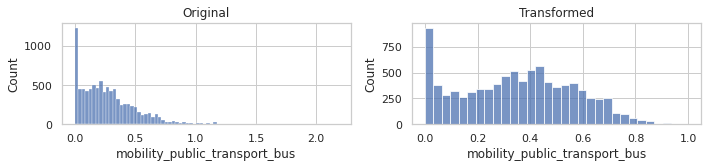

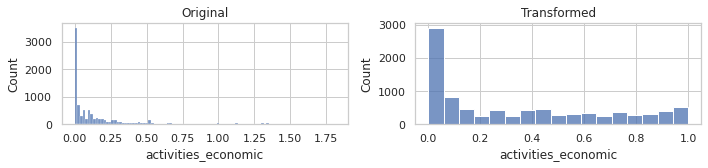

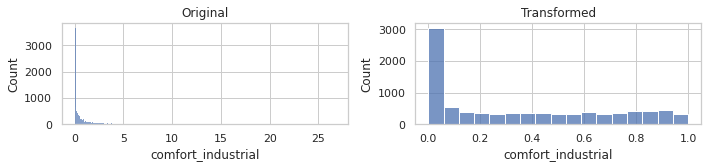

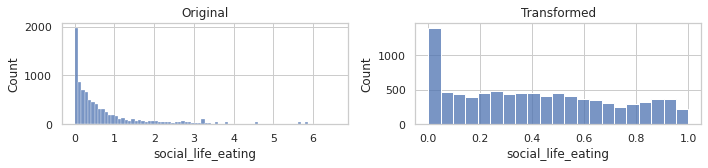

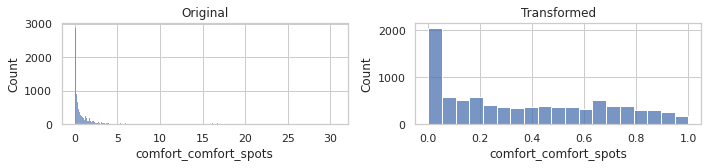

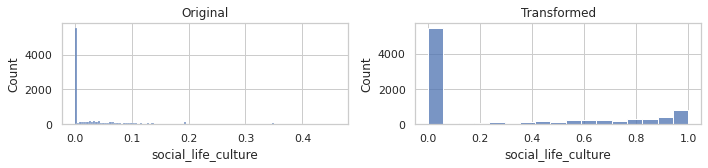

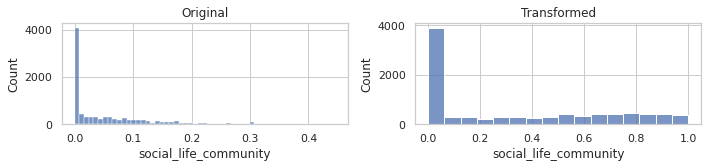

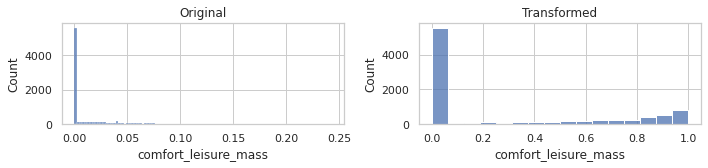

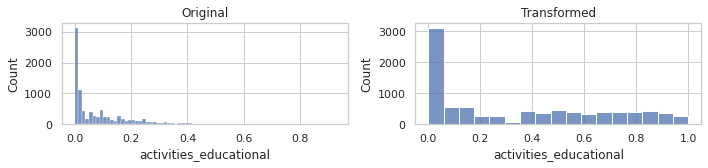

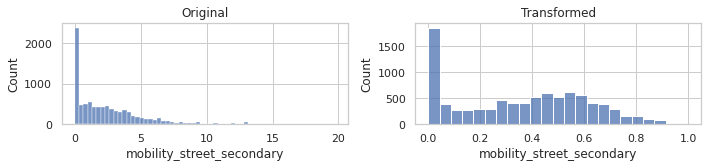

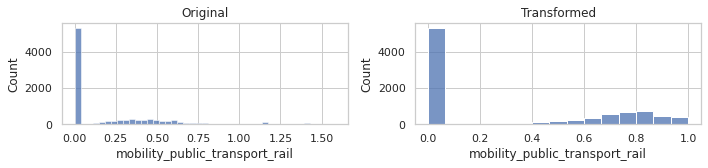

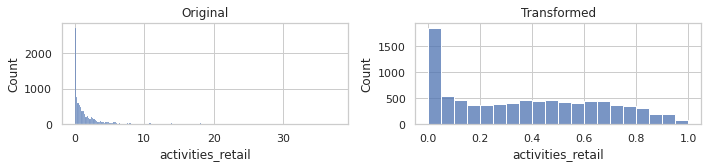

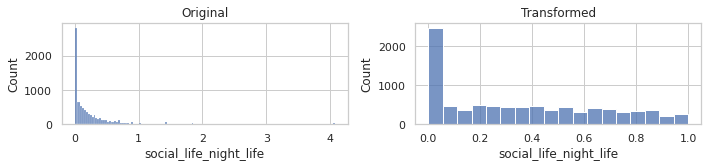

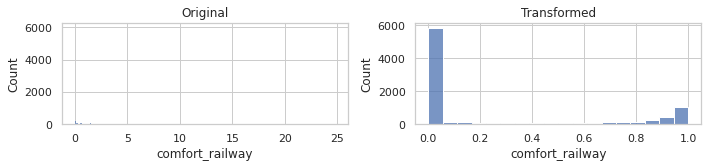

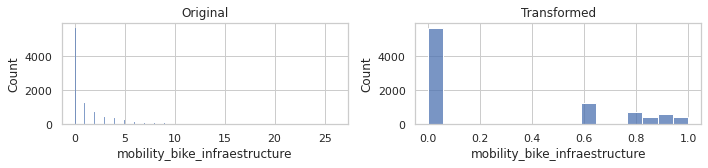

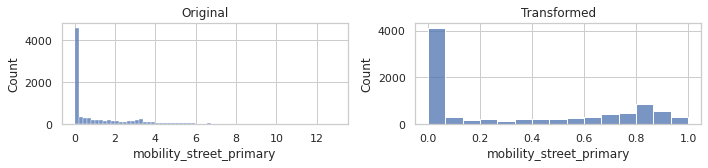

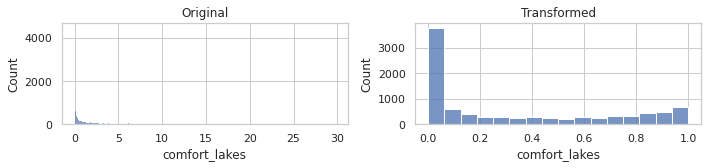

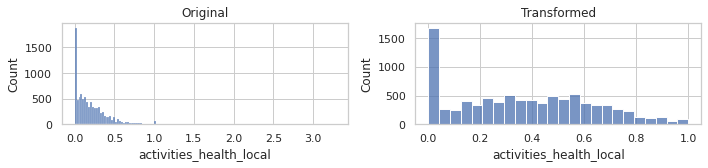

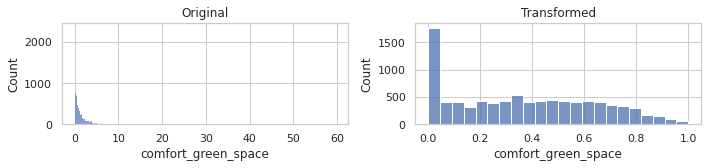

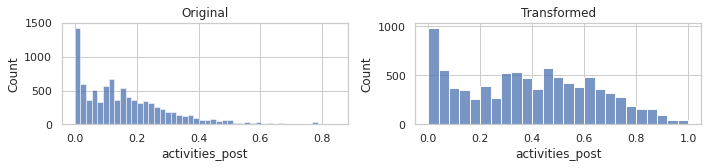

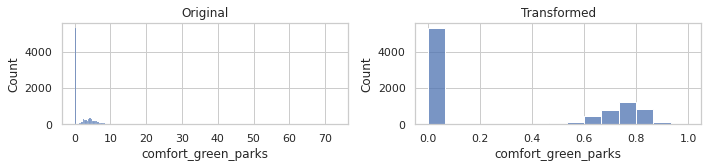

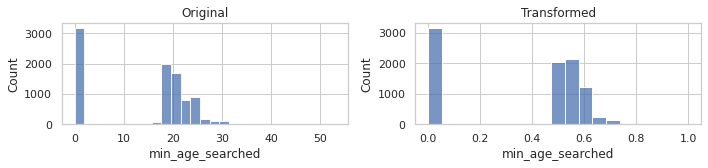

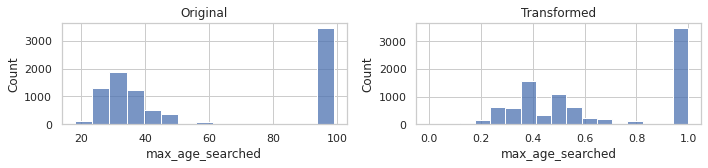

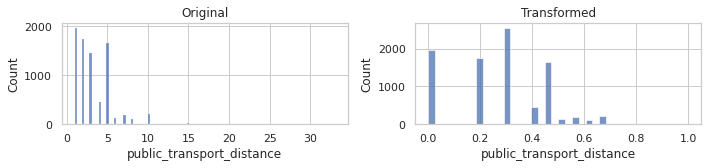

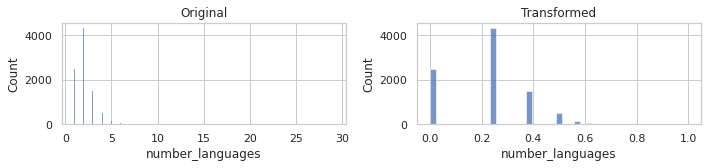

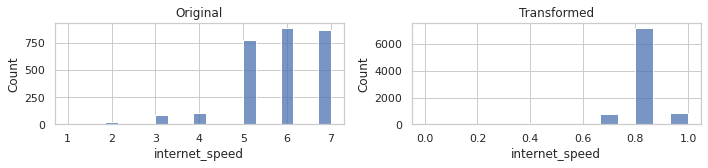

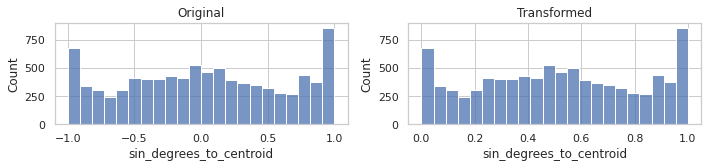

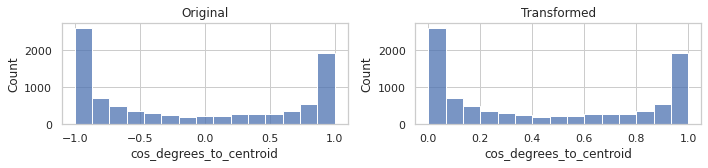

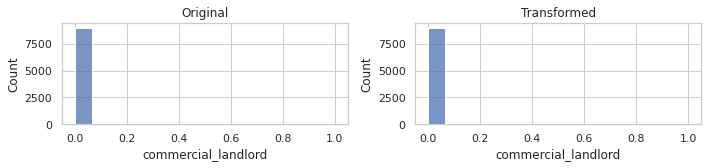

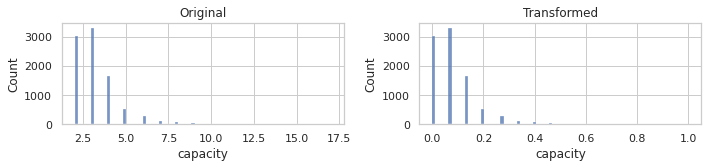

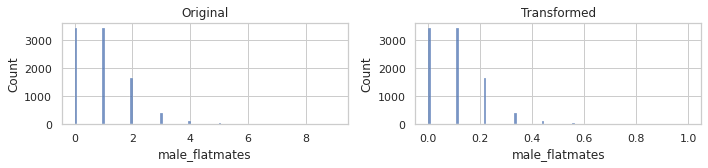

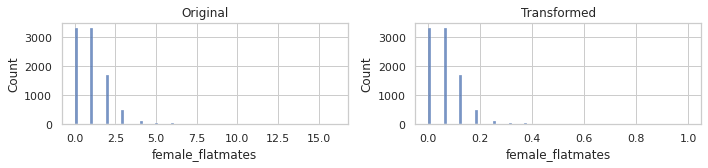

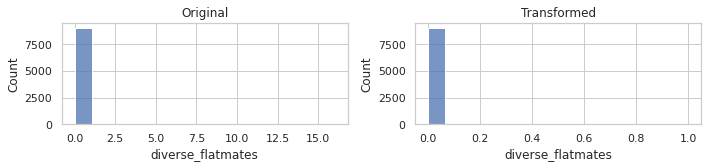

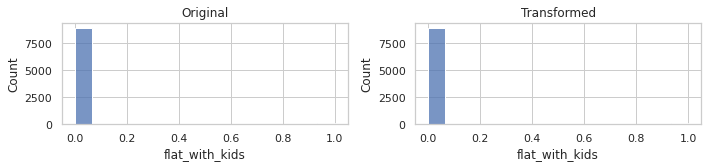

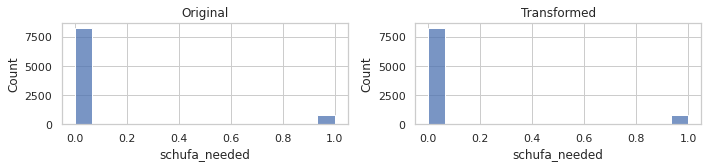

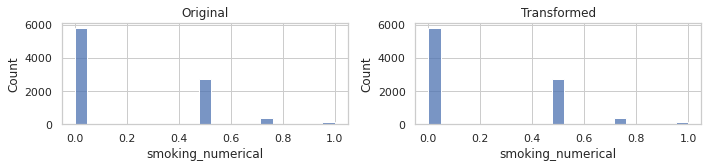

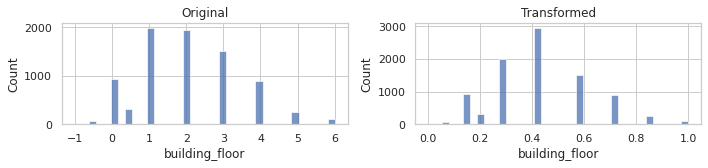

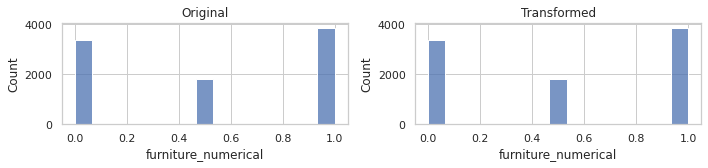

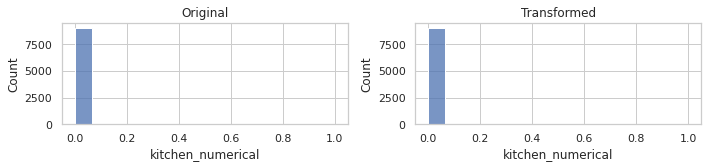

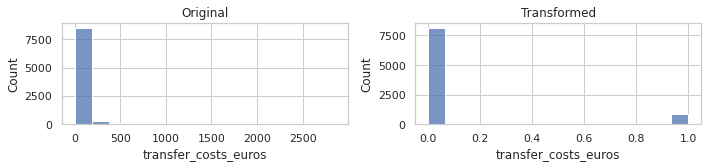

In [19]:
cols_ignore_plot = cols_SimpImpConstNoAns_OHE+features_already_OHE
for col_interest in [col for col in original_cols if col not in cols_ignore_plot]:
    sns.set_theme(style = "whitegrid", font_scale= 1)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))

    sns.histplot(data=df_filtered, x = col_interest, kde=False, ax=ax1).set(title='Original')
    sns.histplot(data=df_processed, x = col_interest, kde=False, ax=ax2).set(title='Transformed')

    plt.tight_layout();

# Minimize features

In [90]:
# List of features to be ignored during analyis. See https://inmachineswetrust.com/posts/drop-first-columns/
features_ignore_analysis = cols_SimpImpConstNoAns_OHE + ['tv','shower_type','floor_type','extras','languages','wg_type']
features_ignore_analysis = [col+'_' for col in features_ignore_analysis]
features_ignore_analysis = [cols for cols in df_processed.columns if any(substring in cols for substring in features_ignore_analysis)]\
+ ['commercial_landlord','flat_with_kids','schufa_needed'] + ['internet_dsl','internet_wlan','internet_flatrate']
features_ignore_analysis

['tv_kabel',
 'tv_satellit',
 'shower_type_badewanne',
 'shower_type_dusche',
 'floor_type_dielen',
 'floor_type_parkett',
 'floor_type_laminat',
 'floor_type_teppich',
 'floor_type_fliesen',
 'floor_type_pvc',
 'floor_type_fußbodenheizung',
 'extras_waschmaschine',
 'extras_spuelmaschine',
 'extras_terrasse',
 'extras_balkon',
 'extras_garten',
 'extras_gartenmitbenutzung',
 'extras_keller',
 'extras_aufzug',
 'extras_haustiere',
 'extras_fahrradkeller',
 'extras_dachboden',
 'languages_deutsch',
 'languages_englisch',
 'wg_type_studenten',
 'wg_type_keine_zweck',
 'wg_type_maenner',
 'wg_type_business',
 'wg_type_wohnheim',
 'wg_type_vegetarisch_vegan',
 'wg_type_alleinerziehende',
 'wg_type_funktionale',
 'wg_type_berufstaetigen',
 'wg_type_gemischte',
 'wg_type_mit_kindern',
 'wg_type_verbindung',
 'wg_type_lgbtqia',
 'wg_type_senioren',
 'wg_type_inklusive',
 'wg_type_wg_neugruendung',
 'city_Aachen',
 'city_Berlin',
 'city_Bonn',
 'city_Bremen',
 'city_Darmstadt',
 'city_Dresden'

In [86]:
df_processed = pd.DataFrame(
                            preprocessor_transformer.fit_transform(df_filtered), 
                            columns=preprocessor_transformer.get_feature_names_out()
                            )

In [87]:
df_minimal = df_processed[[col for col in df_processed.columns if col not in features_ignore_analysis]]

In [88]:
# Define columns to be tested. Don't test the target, commercial_landlord and 'city'
cols_to_search = [col for col in df_minimal.columns if col not in [target]]
# cols_to_search = [col for col in cols_to_search if not col.startswith('city_')]

cols_exclude_minimization = []
for col in cols_to_search:
    # How many times the most frequent val exists
    most_freq_count = list(df_minimal[col].value_counts())[0]
    
    if most_freq_count > len(df_minimal)*0.95:
        cols_exclude_minimization.append(col)

        
# Exclude all columns (except cities) with >99% of the same value (0) as it contains very little information
df_minimal = df_minimal.drop(columns=cols_exclude_minimization)
df_minimal.shape

(9074, 43)

In [89]:
cols_exclude_minimization

['diverse_flatmates', 'kitchen_numerical']

# Colinearity

In [24]:
df_VIF = df_minimal.copy()

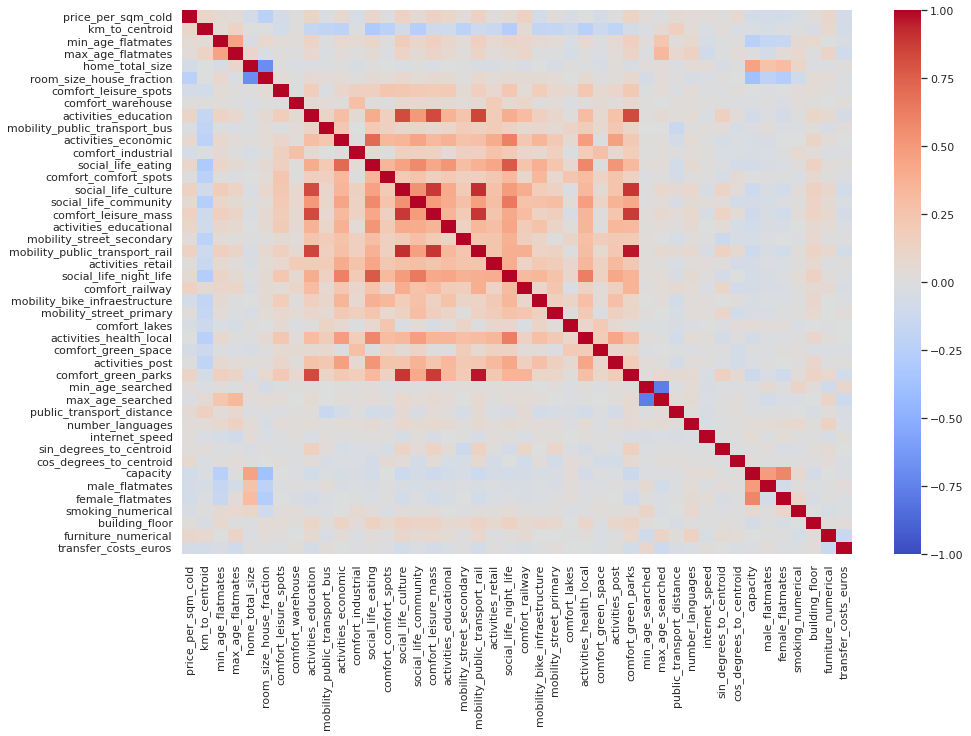

In [25]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

data_corr = df_minimal.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-1, vmax=1);

In [26]:
cols_to_exclude_VIF = [#'mobility_public_transport_rail',
#                         'parking_schlechte Parkmöglichkeiten',
#                         'rental_length_term_plus540days',
#                         'gender_searched_Egal',
#                         'internet_speed',
#                        'heating_no_answer',
#                         'max_age_searched',
#                         'days_available',
#                         'min_age_flatmates',
#                         'min_age_searched',
#                         #'age_category_searched_20_100',
#                         #'extras_gartenmitbenutzung',
                       ]

# df_analysed = df_analysed.drop(columns=cols_to_exclude_VIF)

In [27]:
# These are columns that are always removed, so I'm removing them prematurely to reduce the calculation time
df_VIF = df_VIF.drop(columns = cols_to_exclude_VIF)

In [28]:
data_corr = df_VIF.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
# corr_df['correlation'] = -corr_df['correlation'] # Invert signal to see negative correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
1218,comfort_green_parks,social_life_culture,0.894168
630,social_life_culture,comfort_green_parks,0.894168
702,comfort_leisure_mass,social_life_culture,0.885347
618,social_life_culture,comfort_leisure_mass,0.885347
1220,comfort_green_parks,comfort_leisure_mass,0.877002
716,comfort_leisure_mass,comfort_green_parks,0.877002
372,activities_education,comfort_green_parks,0.835322
1212,comfort_green_parks,activities_education,0.835322
696,comfort_leisure_mass,activities_education,0.829716
360,activities_education,comfort_leisure_mass,0.829716


In [29]:
# Automatized Variation Inflation Factor (VIF) analysis
# Removing columns must be done one at a time because they influence each others VIF results

remove = True
while remove:
    df = pd.DataFrame()
    
    selected_columns = [target] # Ignore the targer column
    selected_columns = [col for col in df_VIF.columns.to_list() if col not in selected_columns]

    df["features"] = selected_columns

    df["vif_index"] = [vif(df_VIF[selected_columns].values, i) for i in range(df_VIF[selected_columns].shape[1])]

    df = round(df.sort_values(by="vif_index", ascending = False),2)
    
    df = df.head(1)

    if float(df.vif_index) >= 10:
        print(df)
        cols_to_exclude_VIF = cols_to_exclude_VIF + df.features.to_list()
        df_VIF = df_VIF.drop(columns = df.features)
    else:
        remove = False

cols_to_exclude_VIF

          features  vif_index
32  internet_speed      33.21
               features  vif_index
27  comfort_green_parks      13.64
              features  vif_index
11  social_life_eating      11.76
               features  vif_index
12  social_life_culture      10.11


['mobility_public_transport_rail',
 'internet_speed',
 'comfort_green_parks',
 'social_life_eating',
 'social_life_culture']

In [30]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()


selected_columns = [col for col in df_VIF.columns.to_list() if col not in [target]]

df["features"] = selected_columns

df["vif_index"] = [vif(df_VIF[selected_columns].values, i) for i in range(df_VIF[selected_columns].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)[:10]

,features,vif_index
26,max_age_searched,9.21
17,social_life_night_life,6.77
35,building_floor,5.89
13,comfort_leisure_mass,5.71
7,activities_education,5.46
22,activities_health_local,5.44
31,capacity,4.97
24,activities_post,4.89
25,min_age_searched,4.56
9,activities_economic,4.17


In [31]:
df_analysed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 8344858 to 8171482
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price_per_sqm_cold             9074 non-null   float64
 1   km_to_centroid                 9074 non-null   float64
 2   min_age_flatmates              9074 non-null   float64
 3   max_age_flatmates              9074 non-null   float64
 4   home_total_size                9074 non-null   float64
 5   room_size_house_fraction       9074 non-null   float64
 6   comfort_leisure_spots          9074 non-null   float64
 7   comfort_warehouse              9074 non-null   float64
 8   activities_education           9074 non-null   float64
 9   mobility_public_transport_bus  9074 non-null   float64
 10  activities_economic            9074 non-null   float64
 11  comfort_industrial             9074 non-null   float64
 12  comfort_comfort_spots          9074 non

# Feature permutation

In [32]:
df_permuted = df_analysed.copy()

## Permutation analysis

In [33]:
X = df_permuted.drop(columns=[target])
y = df_permuted[target]

model = Ridge().fit(X, y) # Fit model

permutation_score = permutation_importance(model, X, y,
                                           scoring = ['r2','neg_root_mean_squared_error'],
                                           n_repeats=100, n_jobs=-1) # Perform Permutation

In [35]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score['r2'].importances_mean,
                                       permutation_score['r2'].importances_std,
                                        permutation_score['neg_root_mean_squared_error'].importances_mean,
                                       permutation_score['neg_root_mean_squared_error'].importances_std)).T) # Unstack results

importance_df.columns=['feature',
                       'r2 score decrease','r2 score decrease std',
                       'RMSE score increase','RMSE score increase std']

In [36]:
importance_df = importance_df.sort_values(by="r2 score decrease", ascending = False) # Order by importance
importance_df[:50]

,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
4,room_size_house_fraction,0.641332,0.012532,2.993121,0.05066
3,home_total_size,0.335323,0.008897,1.679119,0.040732
0,km_to_centroid,0.021311,0.001714,0.116849,0.009331
33,female_flatmates,0.020757,0.001824,0.113835,0.009936
19,mobility_bike_infraestructure,0.018484,0.001718,0.101447,0.009376
14,activities_educational,0.016995,0.001528,0.093317,0.008341
13,comfort_leisure_mass,0.016078,0.001583,0.088311,0.008646
32,male_flatmates,0.014688,0.001542,0.080711,0.008434
18,comfort_railway,0.01354,0.001234,0.074436,0.006752
30,cos_degrees_to_centroid,0.011133,0.00132,0.061252,0.007237


In [37]:
top_features = []
scores = []

for features in range(1, len(importance_df)): # Loop over the total number of features
    
    most_important_features = list(importance_df.head(features).feature) # List the name of the features in specific loop
   
    X_reduced = X[most_important_features] # Make feature set with the selected features
    
    cv_results = cross_val_score(model, X_reduced, y, cv=10) # cross validate
    
    scores.append(cv_results.mean()) # Append scores
    
    top_features.append(features)  # Append number of features

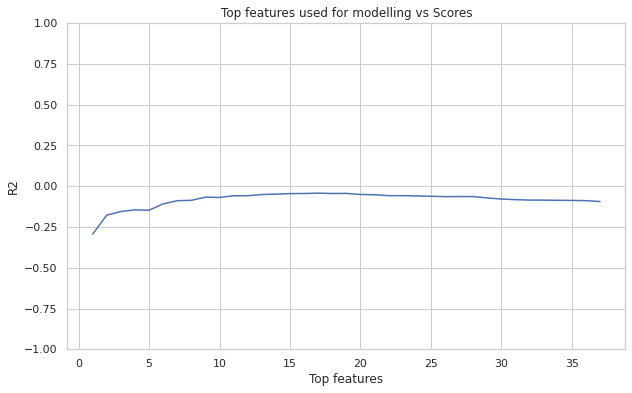

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(top_features, scores)
plt.title('Top features used for modelling vs Scores')
# plt.xlim([0,100])
plt.ylim([-1,1])
plt.xlabel('Top features')
plt.ylabel('R2');

In [39]:
importance_df_selected = importance_df[importance_df['r2 score decrease']>= 0.001]
columns_excluded_permutation = importance_df[importance_df['r2 score decrease']< 0.001]
# max_score_n_features = scores.index(max(scores))
# importance_df_selected = importance_df.head(max_score_n_features)
print(importance_df_selected.shape)
importance_df_selected

(24, 5)


,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
4,room_size_house_fraction,0.641332,0.012532,2.993121,0.05066
3,home_total_size,0.335323,0.008897,1.679119,0.040732
0,km_to_centroid,0.021311,0.001714,0.116849,0.009331
33,female_flatmates,0.020757,0.001824,0.113835,0.009936
19,mobility_bike_infraestructure,0.018484,0.001718,0.101447,0.009376
14,activities_educational,0.016995,0.001528,0.093317,0.008341
13,comfort_leisure_mass,0.016078,0.001583,0.088311,0.008646
32,male_flatmates,0.014688,0.001542,0.080711,0.008434
18,comfort_railway,0.01354,0.001234,0.074436,0.006752
30,cos_degrees_to_centroid,0.011133,0.00132,0.061252,0.007237


In [40]:
important_features = importance_df_selected.feature.to_list()

In [41]:
columns_excluded_permutation = columns_excluded_permutation.feature.to_list()
columns_excluded_permutation

['capacity',
 'activities_health_local',
 'public_transport_distance',
 'social_life_night_life',
 'mobility_public_transport_bus',
 'social_life_community',
 'comfort_lakes',
 'activities_education',
 'min_age_searched',
 'building_floor',
 'number_languages',
 'comfort_warehouse',
 'activities_retail',
 'max_age_flatmates']

# Predictive Power Score

In [42]:
# ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but I have scikit-learn 1.1.2 which is incompatible.

In [43]:
# A correlation analysis that detects assimetric, also non-linear and numeric plus categorical relationships
# assimetric: ZIP predicts city but the city is a poor predictor of ZIP code
# also non-linear: uses Decision Tree to find relationships that might be linear or not
# numeric plus categorical: finds relationships also in categorical features
# https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [44]:
# pps_matrix = pps.matrix(df_analysed[important_features])

In [45]:
# sns.set_theme(style = "whitegrid", font_scale= 1)
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 35))

# matrix_df = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
# sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=False, annot_kws={"size": 8});

# Create new processing pipeline after analysis

In [46]:
columns_to_remove = sorted(cols_exclude_minimization + cols_to_exclude_VIF + columns_excluded_permutation)
columns_to_remove

['activities_education',
 'activities_health_local',
 'activities_retail',
 'building_floor',
 'capacity',
 'comfort_green_parks',
 'comfort_lakes',
 'comfort_warehouse',
 'diverse_flatmates',
 'internet_speed',
 'kitchen_numerical',
 'max_age_flatmates',
 'min_age_searched',
 'mobility_public_transport_bus',
 'mobility_public_transport_rail',
 'number_languages',
 'public_transport_distance',
 'social_life_community',
 'social_life_culture',
 'social_life_eating',
 'social_life_night_life']

In [47]:
preprocessor_analysed = ColumnTransformer([
    ('pipeline-1', PowerTrans_SimpImpMean, [col for col in cols_PowerTrans_SimpImpMean if col not in columns_to_remove]),
    ('pipeline-2', PowerTrans_SimpImpMedian_MinMaxScaler, [col for col in cols_PowerTrans_SimpImpMedian_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-3', SimpImpMean_MinMaxScaler, [col for col in cols_SimpImpMean_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-4', SimpImpMedian_MinMaxScaler, [col for col in cols_SimpImpMedian_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-5', SimpImpConst0_PowerTrans_MinMaxScaler, [col for col in cols_SimpImpConst0_PowerTrans_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-6', SimpImpConstNoAns_OHE, [col for col in cols_SimpImpConstNoAns_OHE if col not in columns_to_remove])
     ],
    remainder='drop',
    verbose_feature_names_out=False)
preprocessor_analysed

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['km_to_centroid', 'min_age_flatmates',
                                  'home_total_size',
                                  'room_size_house_fraction']),
                                ('pipeline-2',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('PowerTransformer',
                                                  PowerTransformer()),
                                                 ('MinM...
                                                  PowerTransformer()),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['transfer_costs_euros']),
                                ('pipeline-6',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(fill_value='no_answer',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 ['city', 'rental_length_term',
                                  'gender_searched', 'building_type', 'heating',
                                  'parking'])],
                  verbose_feature_names_out=False)

#  Model hyper-parametrization with GridSearchCV

In [48]:
# Get transformed table with corresponding column names
X = pd.DataFrame(
                preprocessor_analysed.fit_transform(df_filtered), 
                columns=preprocessor_analysed.get_feature_names_out()
                )

y = df_filtered[target]


In [49]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Ridge linear Regression

In [50]:
%%time
# Instanciate model
model = Ridge()

# Hyperparameter search space
search_space = {
    'alpha': [1,10,100,1000],
    'tol': [0, 0.001,0.1,1],
    'solver': ['lsqr','auto']# auto, 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

# Instanciate GridSearchCV
ridge_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


ridge_rsearch.fit(X,y)
report_best_scores(ridge_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.383 (std: 1.102)
Parameters: {'alpha': 10, 'solver': 'auto', 'tol': 0}

Model with rank: 1
Mean validation score: -7.383 (std: 1.102)
Parameters: {'alpha': 10, 'solver': 'auto', 'tol': 0.001}

Model with rank: 1
Mean validation score: -7.383 (std: 1.102)
Parameters: {'alpha': 10, 'solver': 'auto', 'tol': 0.1}

Model with rank: 1
Mean validation score: -7.383 (std: 1.102)
Parameters: {'alpha': 10, 'solver': 'auto', 'tol': 1}

CPU times: user 393 ms, sys: 310 ms, total: 703 ms
Wall time: 2.76 s


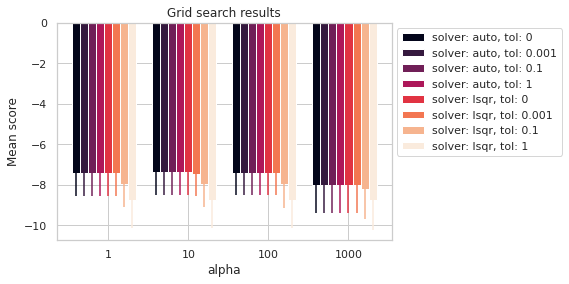

In [51]:
plot.grid_search(ridge_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Lasso linear Regression

In [52]:
%%time
# Instanciate model
model = Lasso()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [0.1,1,10,100],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
lasso_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


lasso_rsearch.fit(X,y)
report_best_scores(lasso_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.532 (std: 0.707)
Parameters: {'alpha': 0.001, 'selection': 'cyclic', 'tol': 0.1}

CPU times: user 805 ms, sys: 915 ms, total: 1.72 s
Wall time: 2.2 s


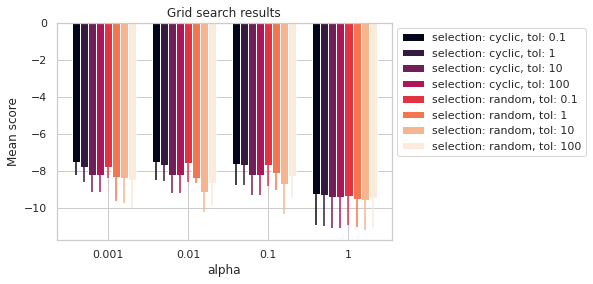

In [53]:
plot.grid_search(lasso_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## ElasticNet linear Regression

In [54]:
%%time
# Instanciate model
model = ElasticNet()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
elastic_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


elastic_rsearch.fit(X,y)
report_best_scores(elastic_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.618 (std: 0.970)
Parameters: {'alpha': 0.01, 'l1_ratio': 0, 'selection': 'cyclic', 'tol': 1}

CPU times: user 898 ms, sys: 103 ms, total: 1 s
Wall time: 4.49 s


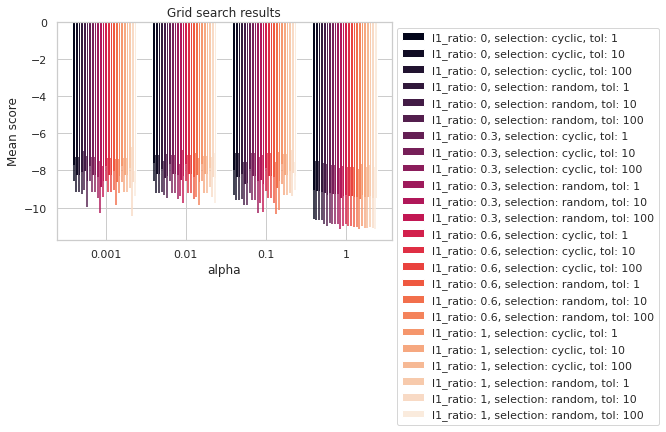

In [55]:
plot.grid_search(elastic_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Stochastic Gradient Descend

In [56]:
%%time
# Instanciate model
model = SGDRegressor()

# Hyperparameter search space
search_space = {
    'loss':['squared_error','epsilon_insensitive', 'squared_epsilon_insensitive'],#, 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.0001, 0.001,0.01],
    'penalty': ['elasticnet'],#['l1','l2','elasticnet'],
    'tol': [10],#[1,10,100],
    'l1_ratio': [1],#[0,0.3,0.6,1],
    'epsilon': [1,10,100],
    'learning_rate': ['invscaling'],#,'constant','optimal','adaptive'],
    'eta0': [0.001,0.01,0.1], 
    'power_t': [0.25],
    'early_stopping': [True]
}

# Instanciate GridSearchCV
sgdr_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


sgdr_rsearch.fit(X,y)
report_best_scores(sgdr_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.340 (std: 1.145)
Parameters: {'alpha': 0.0001, 'early_stopping': True, 'epsilon': 1, 'eta0': 0.01, 'l1_ratio': 1, 'learning_rate': 'invscaling', 'loss': 'squared_epsilon_insensitive', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 10}

CPU times: user 848 ms, sys: 235 ms, total: 1.08 s
Wall time: 5.99 s


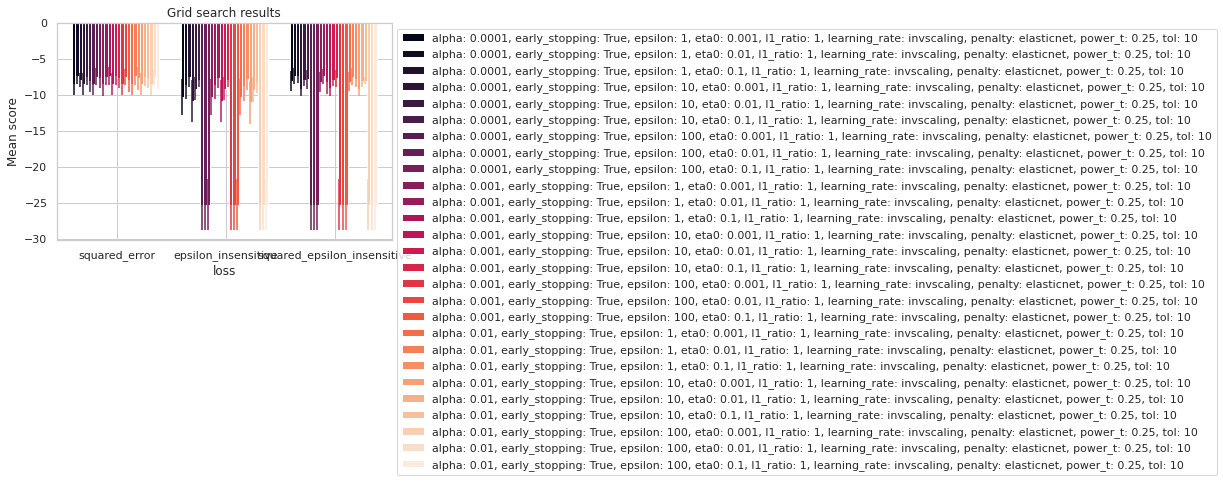

In [57]:
plot.grid_search(sgdr_rsearch.cv_results_, change="loss", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## KNN Regressor

In [58]:
%%time
# Instanciate model
model = KNeighborsRegressor(n_jobs=-1)

# Hyperparameter search space
search_space = {
    'n_neighbors': range(30,50,1),
    'weights': ['distance'],#['uniform', 'distance'],
    'algorithm': ['brute'],#['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [2]#range(2,15,1)
}

# Instanciate GridSearchCV
knn_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


knn_rsearch.fit(X,y)
report_best_scores(knn_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.698 (std: 1.541)
Parameters: {'algorithm': 'brute', 'leaf_size': 2, 'n_neighbors': 38, 'weights': 'distance'}

CPU times: user 450 ms, sys: 57.1 ms, total: 507 ms
Wall time: 17.1 s


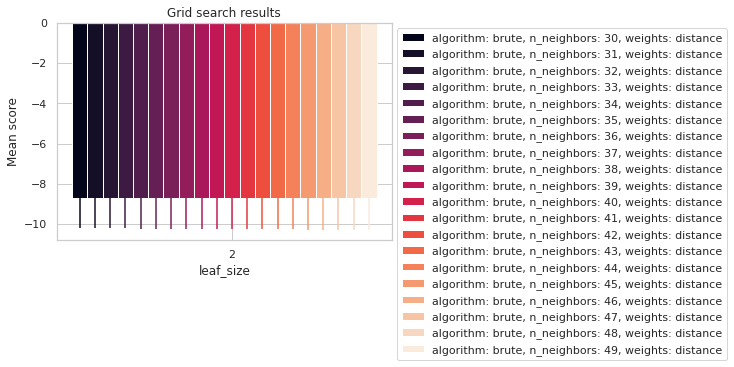

In [59]:
plot.grid_search(knn_rsearch.cv_results_, change="leaf_size", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Support Vector Machine

In [60]:
%%time
# Instanciate model
model = SVR()

# Hyperparameter search space
search_space = {
    'kernel': ['poly'],#['linear','poly','sigmoid', 'rbf'],
    'degree': range(2,5,1),
    'C': [10,100,1000],
    'tol': [0.001],#[0.001,0.01,0.1],
    'gamma': ['auto'],#[0,0.1,1,'scale','auto'],
    'coef0': [0],#[0,0.1,1],
    'epsilon': [1],#[0.1,1,10]
}

# Instanciate GridSearchCV
svm_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


svm_rsearch.fit(X,y)
report_best_scores(svm_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.509 (std: 1.280)
Parameters: {'C': 100, 'coef0': 0, 'degree': 2, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'poly', 'tol': 0.001}

CPU times: user 4.63 s, sys: 67.7 ms, total: 4.7 s
Wall time: 1min 40s


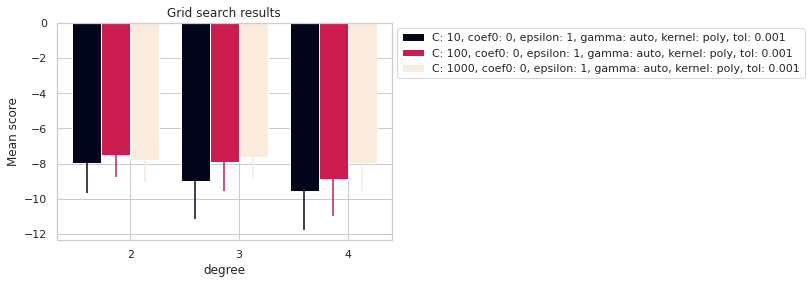

In [61]:
plot.grid_search(svm_rsearch.cv_results_, change="degree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Decision Tree Regressor

In [62]:
%%time
# Instanciate model
model = DecisionTreeRegressor()

# Hyperparameter search space
search_space = {
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best','random'],
    'max_depth': range(2,5,1),
    'min_samples_split': range(14,17,1),
    'min_samples_leaf': range(2,5,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [0.8],#[0.6,0.7,0.8,0.9],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.3],#[0.2,0.3,0.4,0.5],
    'ccp_alpha':[0.0],#[0.2,0.25,0.3,0.35],
}

# Instanciate GridSearchCV
tree_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


tree_rsearch.fit(X,y)
report_best_scores(tree_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.498 (std: 1.364)
Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 0.8, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}

CPU times: user 436 ms, sys: 37.6 ms, total: 473 ms
Wall time: 2.43 s


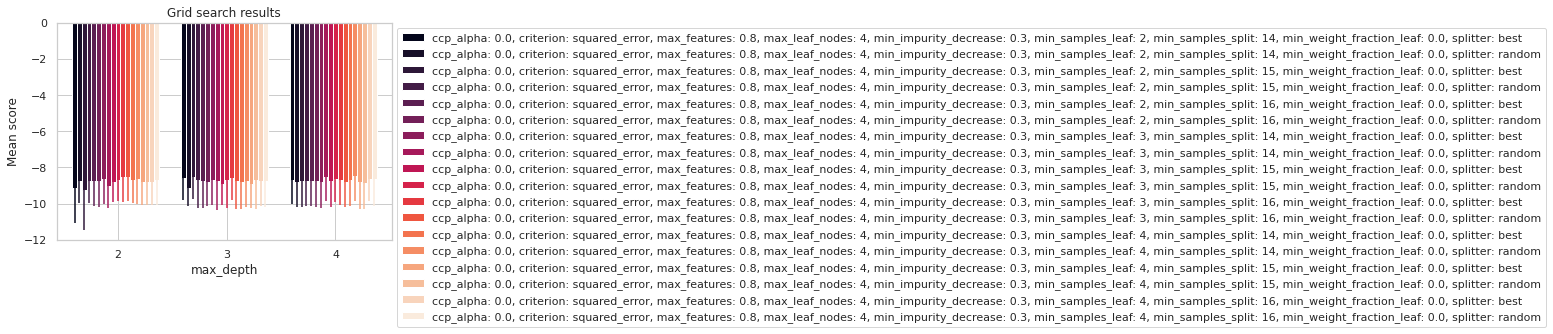

In [63]:
plot.grid_search(tree_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Random Forest Regressor

In [64]:
%%time
# Instanciate model
model = RandomForestRegressor()

# Hyperparameter search space
search_space = {
    'n_jobs':[-1],
    'n_estimators': [100],#[100,200,500,1000],
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': range(5,20,5),
    'min_samples_split': [4],#range(3,6,1),
    'min_samples_leaf': [3],#range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [1.0],#[0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'bootstrap':[False],#[True, False]
    'ccp_alpha':[0.0],
}

# Instanciate GridSearchCV
rand_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


rand_rsearch.fit(X,y)
report_best_scores(rand_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.696 (std: 1.434)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1}

Model with rank: 1
Mean validation score: -8.696 (std: 1.434)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1}

Model with rank: 1
Mean validation score: -8.696 (std: 1.434)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf'

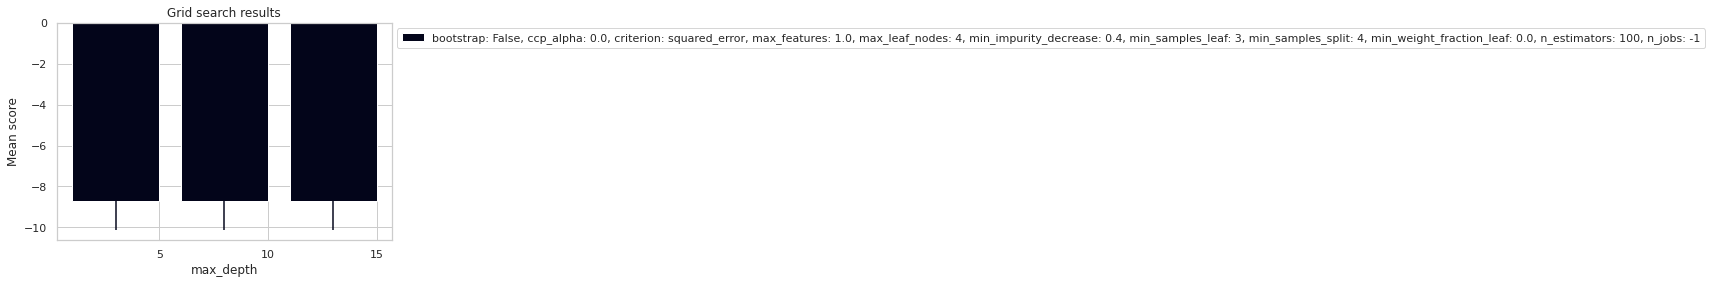

In [65]:
plot.grid_search(rand_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Gradient Boosting Regressor

In [66]:
%%time
# Instanciate model
model = GradientBoostingRegressor()

# Hyperparameter search space
search_space = {
    'learning_rate': [0.1],#[0.001,0.01,0.1],
    'n_estimators': [100],#[100,200,500,1000],
    'loss': ['squared_error'],#['squared_error', 'absolute_error', 'huber', 'quantile'],
    'subsample':[0.66],#[0.33,0.66,1.0],
    'criterion': ['friedman_mse'],#['squared_error', 'friedman_mse'],
    'min_samples_split': [7],#range(6,8,1),
    'min_samples_leaf': [3],#range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_depth': range(2,4,1),
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'max_features': [0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1),
    'ccp_alpha':[0.3],#[0.25,0.3,0.35],
}

# Instanciate GridSearchCV
gradboos_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


gradboos_rsearch.fit(X,y)
report_best_scores(gradboos_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.694 (std: 1.136)
Parameters: {'ccp_alpha': 0.3, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 0.9, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'subsample': 0.66}

CPU times: user 2.28 s, sys: 7.85 ms, total: 2.29 s
Wall time: 20 s


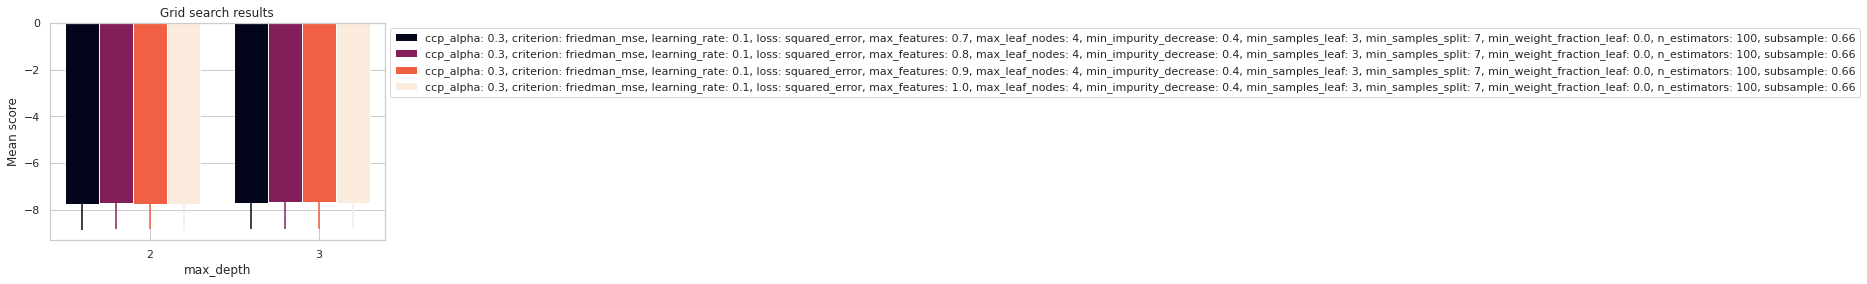

In [67]:
plot.grid_search(gradboos_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Extreme Gradient Boosting (XGB) Regressor

In [68]:
%%time
# Instanciate model
model = XGBRegressor()

# Hyperparameter search space
search_space = {
    "colsample_bytree": [0.6,0.7,0.8],
#     "gamma": [0.3,0.4,0.5],
    "learning_rate": [0.1],#[0.1,0.01,0.001], # default 0.1 
    "max_depth": range(2,4,1), # default 3
    "n_estimators": range(100,150,10), # default 100
    "subsample": [0.2],#[0.1,0.2,0.3]
}

# Instanciate GridSearchCV
xgb_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


xgb_rsearch.fit(X,y)
report_best_scores(xgb_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.433 (std: 1.067)
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 140, 'subsample': 0.2}

CPU times: user 5.79 s, sys: 0 ns, total: 5.79 s
Wall time: 52.2 s


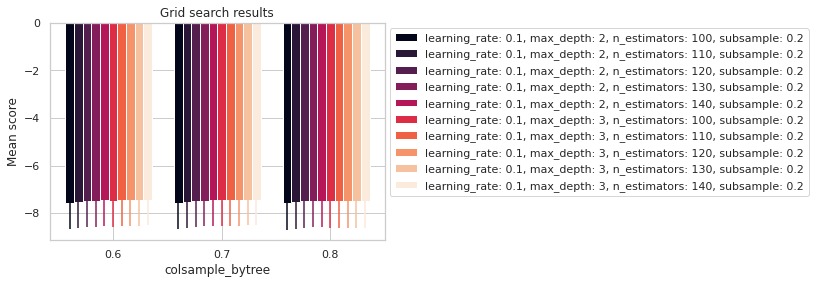

In [69]:
plot.grid_search(xgb_rsearch.cv_results_, change="colsample_bytree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

# Building model

In [70]:
# Get transformed table with corresponding column names
X = pd.DataFrame(
                preprocessor_analysed.fit_transform(df_filtered), 
                columns=preprocessor_analysed.get_feature_names_out()
                )

y = df_filtered[target]

## Compare all models

In [71]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = 0)

scores = pd.DataFrame(columns=['model','r2','explained_variance','MSE',#'MSLE',
                               'MAE','RMSE'])

model = None

for mod in [LinearRegression(n_jobs=-1),
            ridge_rsearch.best_estimator_,
            lasso_rsearch.best_estimator_,
            elastic_rsearch.best_estimator_,
            sgdr_rsearch.best_estimator_,
            knn_rsearch.best_estimator_,
            svm_rsearch.best_estimator_,
            tree_rsearch.best_estimator_,
            rand_rsearch.best_estimator_,
            gradboos_rsearch.best_estimator_,
            xgb_rsearch.best_estimator_,
             ]:
    
    mod.fit(X_train,y_train)
    
    mod_name = type(mod).__name__
    
    y_pred = mod.predict(X_test)

    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
    mod_r2=metrics.r2_score(y_test, y_pred)
    

    scores = pd.concat([scores, pd.DataFrame.from_dict({'model':[mod_name],
                                 'r2':[round(mod_r2,4)],
                                 'explained_variance':[round(explained_variance,4)],
                                 'MAE':[round(mean_absolute_error,4)],
                                 'MSE':[round(mse,4)],
#                                  'MSLE':[round(mean_squared_log_error,4)],
                                 'RMSE':[round(np.sqrt(mse),4)]   
                                })
                       ]).reset_index(drop=True)
    
    if model is None:
        model = mod
    if mod_r2> model.score(X_test, y_test):
        model = mod
    
scores.sort_values(by='r2', ascending=False)

,model,r2,explained_variance,MSE,MAE,RMSE
1,Ridge,0.5684,0.5687,37.8507,4.5842,6.1523
2,Lasso,0.5672,0.5675,37.9496,4.5993,6.1603
0,LinearRegression,0.5666,0.5668,38.0088,4.6058,6.1651
6,SVR,0.5659,0.5724,38.0708,4.5321,6.1702
10,XGBRegressor,0.5632,0.5632,38.3049,4.6382,6.1891
4,SGDRegressor,0.5591,0.5608,38.6615,4.6965,6.2178
3,ElasticNet,0.5278,0.5281,41.4050,4.8198,6.4347
9,GradientBoostingRegressor,0.5104,0.5104,42.9324,5.0062,6.5523
5,KNeighborsRegressor,0.3649,0.3659,55.6963,5.6344,7.4630
8,RandomForestRegressor,0.2908,0.2908,62.1913,6.0853,7.8861


In [72]:
type(model).__name__

'Ridge'

## Create and save best prediction pipeline

In [73]:
pred_pipeline = make_pipeline(preprocessor_analysed,model)

In [74]:
pred_pipeline = pred_pipeline.fit(df_filtered.drop(columns=target),
                                  df_filtered[target])
pred_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer()),
                                                                  ('PowerTransformer',
                                                                   PowerTransformer())]),
                                                  ['km_to_centroid',
                                                   'min_age_flatmates',
                                                   'home_total_size',
                                                   'room_size_house_fraction']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('PowerTr...
                                                                   MinMaxScaler())]),
                                                  ['transfer_costs_euros']),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(fill_value='no_answer',
                                                                                 strategy='constant')),
                                                                  ('OHE',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['city', 'rental_length_term',
                                                   'gender_searched',
                                                   'building_type', 'heating',
                                                   'parking'])],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(alpha=10, tol=0))])

In [ ]:
# Export Pipeline as pickle file
with open("pred_pipeline_allcities.pkl", "wb") as file:
    pickle.dump(pred_pipeline, file)

# Load Pipeline from pickle file
pred_pipeline = pickle.load(open("pred_pipeline_allcities.pkl","rb"))

## Learning curve best prediction pipeline

In [75]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

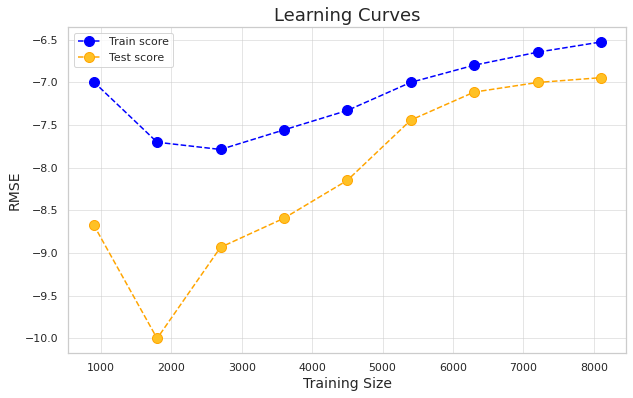

In [76]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

RMSE: 6.524572664650514
RMSE base model (mean value): 9.497055910756675


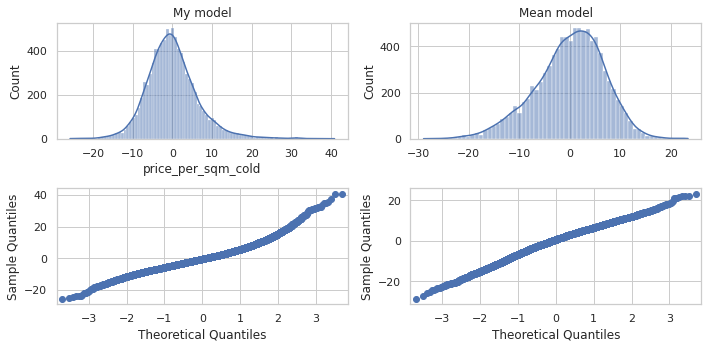

In [77]:
import statsmodels.api as sm
y_pred = pred_pipeline.predict(df_filtered)
y_base = [np.mean(y)]*len(y_pred)
y_true = y#y_test

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model (mean value): {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(y_pred)
residuals = y_true - y_pred
residuals_base = y_base - y_pred

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1).set(title='My model')
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2).set(title='Mean model')

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)
sm.qqplot(residuals_base, ax=ax4)
plt.tight_layout()
fig.show();

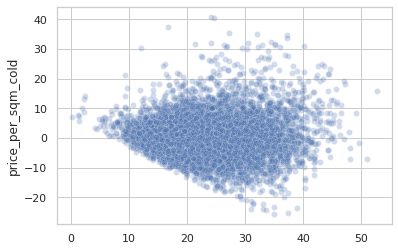

In [78]:
sns.scatterplot(x=y_pred, y=residuals,alpha=0.25);

# Simple linear model

In [79]:
X = pd.DataFrame(
                preprocessor_transformer.fit_transform(df_filtered), 
                columns=preprocessor_transformer.get_feature_names_out()
                )
y = df_filtered[[target]].reset_index()
df_OLS=pd.concat([y,X],axis=1).set_index(keys='id')

# Select data from a specified time period
df_OLS = pd.merge(ads_feat_df['published_on'], df_OLS, left_index=True, right_index=True)
# df_OLS = df_OLS[df_OLS['published_on'] <= '2022-08-01']
# df_OLS = df_OLS[df_OLS['published_on'] > '2022-08-08']

df_OLS.columns = [cols.replace(' ','_') for cols in df_OLS.columns.to_list()]

In [80]:
print(df_OLS.shape)
df_OLS.describe()

(9074, 151)


,price_per_sqm_cold,km_to_centroid,min_age_flatmates,max_age_flatmates,home_total_size,room_size_house_fraction,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,social_life_eating,comfort_comfort_spots,social_life_culture,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,activities_post,comfort_green_parks,min_age_searched,max_age_searched,public_transport_distance,number_languages,internet_speed,sin_degrees_to_centroid,cos_degrees_to_centroid,commercial_landlord,capacity,male_flatmates,female_flatmates,diverse_flatmates,flat_with_kids,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_dsl,internet_wlan,internet_flatrate,transfer_costs_euros,city_Aachen,city_Berlin,city_Bonn,city_Bremen,city_Darmstadt,city_Dresden,city_Frankfurt_am_Main,city_Göttingen,city_Hamburg,city_Hannover,city_Heidelberg,city_Karlsruhe,city_Kiel,city_Köln,city_Leipzig,city_Mainz,city_Mannheim,city_München,city_Münster,city_Nürnberg,city_Regensburg,city_Stuttgart,city_Tübingen,city_Würzburg,rental_length_term_180days,rental_length_term_270days,rental_length_term_30days,rental_length_term_365days,rental_length_term_540days,rental_length_term_90days,rental_length_term_plus540days,gender_searched_Divers,gender_searched_Egal,gender_searched_Frau,gender_searched_Mann,building_type_Altbau,building_type_Doppelhaus,building_type_Einfamilienhaus,building_type_Hochhaus,building_type_Mehrfamilienhaus,building_type_Neubau,building_type_Plattenbau,building_type_Reihenhaus,building_type_no_answer,building_type_sanierter_Altbau,heating_Fernwärme,heating_Gasheizung,heating_Kohleofen,heating_Nachtspeicherofen,heating_Ofenheizung,heating_Zentralheizung,heating_no_answer,parking_Bewohnerparken,parking_Tiefgaragenstellplatz,parking_eigener_Parkplatz,parking_gute_Parkmöglichkeiten,parking_no_answer,parking_schlechte_Parkmöglichkeiten
count,9074.000000,9.074000e+03,9.074000e+03,9.074000e+03,9.074000e+03,9.074000e+03,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.00000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000

In [81]:
# OLS model
formula = target + ' ~ ' + ' + '.join(str(feat) for feat in df_OLS.columns if feat not in [target,'published_on','languages_deutsch']) +' -1'

model = smf.ols(formula = formula, data=df_OLS).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     price_per_sqm_cold   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     72.01
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:46:34   Log-Likelihood:                -29839.
No. Observations:                9074   AIC:                         5.996e+04
Df Residuals:                    8931   BIC:                         6.098e+04
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
km_to_centroid                         -0.4627      0.117     -3.955      0.000      -0.692      -0.233
min_age_flatmates                      -0.0472      0.089     -0.528      0.597      -0.222       0.128
max_age_flatmates                      -0.4057      0.094     -4.309      0.000      -0.590      -0.221
home_total_size                        -4.0216      0.106    -38.024      0.000      -4.229      -3.814
room_size_house_fraction               -5.1969      0.099    -52.696      0.000      -5.390      -5.004
comfort_leisure_spots                  -0.1564      0.230     -0.680      0.497      -0.607       0.295
comfort_warehouse                       0.1915      0.217      0.882      0.378      -0.234       0.617
activities_education                    0.3668      0.433      0.847      0.397      -0.482       1.216
mobility_public_transport_bus          -1.3347      0.387     -3.451      0.001      -2.093      -0.577
activities_economic                     0.1159      0.322      0.360      0.719      -0.516       0.748
comfort_industrial                     -0.3974      0.259     -1.536      0.125      -0.904       0.110
social_life_eating                      2.3836      0.500      4.768      0.000       1.404       3.363
comfort_comfort_spots                  -0.1736      0.273     -0.636      0.525      -0.709       0.362
social_life_culture                    -1.7112      0.591     -2.897      0.004      -2.869      -0.553
social_life_community                  -0.1410      0.328     -0.430      0.667      -0.783       0.502
comfort_leisure_mass                    0.4245      0.488      0.870      0.384      -0.532       1.381
activities_educational                 -0.2406      0.272     -0.885      0.376      -0.773       0.292
mobility_street_secondary               0.2986      0.343      0.870      0.384      -0.374       0.971
mobility_public_transport_rail         -1.4375      0.927     -1.551      0.121      -3.254       0.379
activities_retail                      -0.4145      0.307     -1.352      0.176      -1.016       0.187
social_life_night_life                 -0.0568      0.448     -0.127      0.899      -0.935       0.821
comfort_railway                         0.8204      0.285      2.882      0.004       0.262       1.378
mobility_bike_infraestructure          -0.6201      0.210     -2.955      0.003      -1.031      -0.209
mobility_street_primary                 1.0590      0.236      4.487      0.000       0.596       1.522
comfort_lakes                           0.0164      0.219      0.075      0.940      -0.412       0.445
activities_health_local                 0.2783      0.385      0.723      0.470      -0.477       1.033
comfort_green_space                     0.5318      0.315      1.68

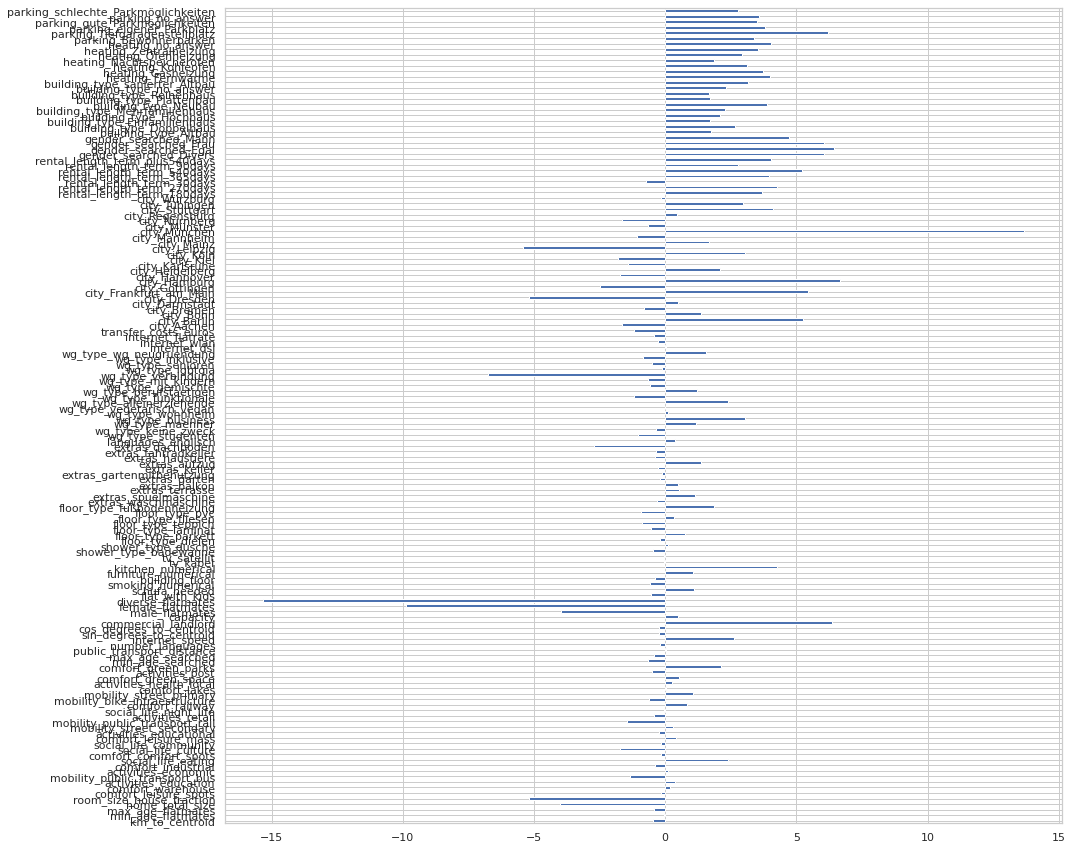

In [82]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model.params[0:].plot(kind='barh');

RMSE: 6.484514020474684
RMSE base model: 9.497055910756675


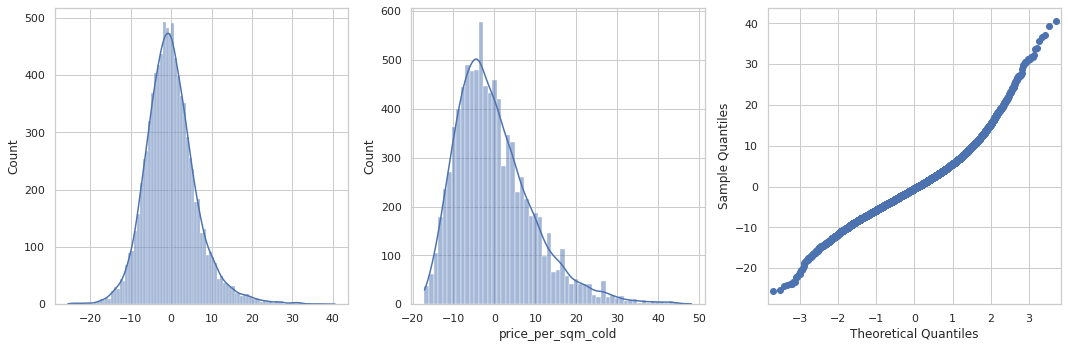

In [83]:
df_city = df_OLS#[df_OLS['city_hannover'] == 1.0]
y_pred = model.predict(df_city)
y_base = [np.mean(df_city[target])]*len(y_pred)
y_true = df_city[target]

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_analysed)
residuals = y_true - y_pred 
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model.resid, ax=ax3)
plt.tight_layout()
fig.show();

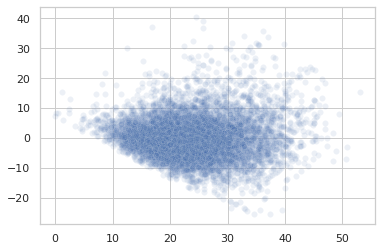

In [84]:
sns.scatterplot(x=y_pred, y=residuals,alpha=0.1);

                                    p_value       coef
variable                                              
city_München                   0.000000e+00  13.668631
city_Hamburg                   6.358608e-77   6.682135
gender_searched_Egal           2.138830e-67   6.440691
commercial_landlord            1.484577e-14   6.371927
parking_Tiefgaragenstellplatz  1.143093e-21   6.207115
...                                     ...        ...
city_Dresden                   6.325614e-33  -5.204396
city_Leipzig                   1.034565e-50  -5.409272
wg_type_verbindung             5.445662e-10  -6.765615
female_flatmates               3.438777e-10  -9.887041
diverse_flatmates              1.623555e-03 -15.331584

[91 rows x 2 columns]


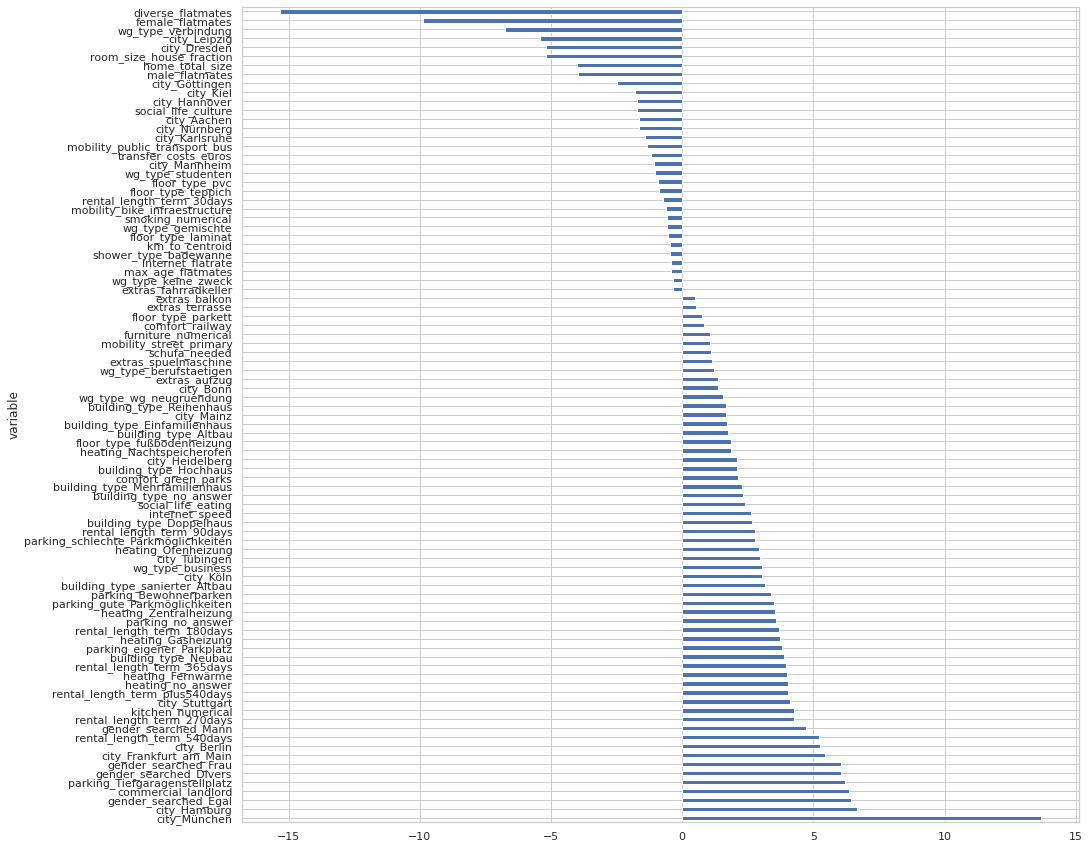

In [85]:
df = return_significative_coef(model).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
df.coef.plot(kind='barh');